# EDH card pair prediction

1. build train / test / dev data set
    1. get EDH card pair recommendations from edhrec.com. these have prediction value 1
    1. generate false pairs (prediction value 0) by randomly generating pairs
    1. split, stratifying on card color identity, card type, rarity.
    1. convert cards into sentences
1. fine-tune
    1. load pre-trained bert model on prediction task "card a, card b --> {yes,no} was edh rec
1. make deck predictions for one of my existing decks

In [4]:
# !pip install datasets transformers

In [5]:
import csv
import itertools
import os
from glob import glob

import datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
from datasets import load_dataset, load_from_disk
from pyarrow.csv import ConvertOptions
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from transformers import (BertConfig, BertTokenizerFast,
                          BertForNextSentencePrediction,
                          DataCollatorWithPadding,
                          PreTrainedModel, PreTrainedTokenizerFast,
                          Trainer, TrainingArguments, )

In [6]:
%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)

I'm getting tired of toggling cells from raw to python code, so here I'll put some flags, and then wrap entire sections in these flags

In [8]:
CARD_SAMPLER_VERSION = 2

IS_LOCAL_LAPTOP = True
BUILD_TTV_DATASETS = True
#USE_CARD_SAMPLER_V2 = False
DO_FINE_TUNING = False
USE_FINE_TUNED_MODEL = False
CHECK_FINE_TUNED_MODEL_RESULTS = False
MAKE_DECK_RECOMMENDATION_DATASETS = False
DO_DECK_RECOMMENDATIONS = False
CHECK_DECK_RECOMMENDATIONS = False

In [9]:
USE_CARD_SAMPLER_V1 = CARD_SAMPLER_VERSION == 1
USE_CARD_SAMPLER_V2 = CARD_SAMPLER_VERSION == 2
USE_CARD_SAMPLER_V3 = CARD_SAMPLER_VERSION == 3

In [10]:
if BUILD_TTV_DATASETS:
    assert IS_LOCAL_LAPTOP

if CHECK_FINE_TUNED_MODEL_RESULTS:
    assert USE_FINE_TUNED_MODEL

if MAKE_DECK_RECOMMENDATION_DATASETS:
    assert IS_LOCAL_LAPTOP

if DO_DECK_RECOMMENDATIONS:
    assert USE_FINE_TUNED_MODEL

if CHECK_DECK_RECOMMENDATIONS:
    assert USE_FINE_TUNED_MODEL
    assert IS_LOCAL_LAPTOP

## build train / test / dev data set

### get EDH card pair recommendations from edhrec.com

these will have prediction value 1

In [12]:
if IS_LOCAL_LAPTOP:
    import mtg.cards
    import mtg.extract.edhrec

    edhrec_cards = (mtg.extract.edhrec.get_commanders_and_cards()
                    [['name', 'commander']])
    edhrec_cards.name = edhrec_cards.name.str.lower()
    edhrec_cards.commander = edhrec_cards.commander.str.lower()

edhrec_cards.head() if IS_LOCAL_LAPTOP else None

,name,commander
0,forsaken monument,"kozilek, the great distortion"
1,war room,"kozilek, the great distortion"
2,commander's plate,"kozilek, the great distortion"
3,guildless commons,"kozilek, the great distortion"
4,skyclave relic,"kozilek, the great distortion"


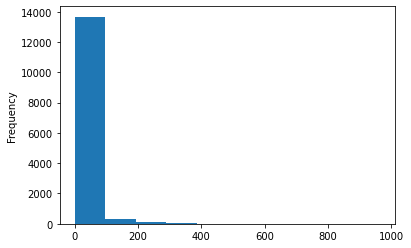

In [13]:
if IS_LOCAL_LAPTOP:
    # most common cards
    edhrec_cards.name.value_counts().plot.hist()

In [14]:
if IS_LOCAL_LAPTOP:
    # most common cards
    vc = edhrec_cards.name.value_counts()
vc.head() if IS_LOCAL_LAPTOP else None

sol ring                   962
swiftfoot boots            846
lightning greaves          840
temple of the false god    835
reliquary tower            829
Name: name, dtype: int64

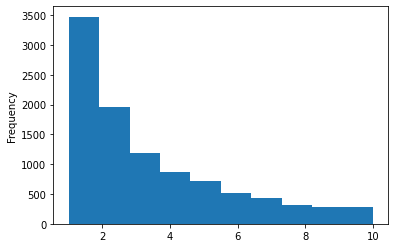

In [15]:
if IS_LOCAL_LAPTOP:
    # most cards appear in only 1 commander recs, up to 500 cards appear
    # in 10 commander recs
    vc[vc <= 10].plot.hist()

if we just ran with this, how many total pairs could we generate this way? basically, for every card in deck X, every other card is a valid pair. that's:

In [16]:
if IS_LOCAL_LAPTOP:
    z = edhrec_cards.commander.value_counts()
    print(f"{int((z * (z - 1) / 2).sum()):,}")

32,256,577


at first I was going to say no way, buuuuuut it's actually not terrible... we want big data, after all

we would need to generate about 32 mil negative labels if that were the dataset we were interested in

### get all cards from mtgjson

to generate false pairs we will randomly select from all cards. about 65% of all MTG cards are referenced on edhrec, but the rest are also, presumably, good choices for 0 labels

In [17]:
if IS_LOCAL_LAPTOP:
    cards = (mtg.cards.cards_df()
             .sort_values(by=['name', 'multiverseId'], ascending=False)
             .groupby('name')
             .first())
    
    cards.index = cards.index.str.lower()

In [20]:
cards.index.str.lower()

Index(['"ach! hans, run!"', '"rumors of my death . . ."',
       '1996 world champion', 'a display of my dark power', 'a good thing',
       'a reckoning approaches', 'awol', 'abandon hope', 'abandon reason',
       'abandoned outpost',
       ...
       'zuran enchanter', 'zuran orb', 'zuran spellcaster',
       'zurgo bellstriker', 'zurgo helmsmasher', 'zurzoth, chaos rider',
       'zyym, mesmeric lord', 'zzzyxas's abyss', '_____', 'capital offense'],
      dtype='object', name='name', length=21814)

In [19]:
cards.head()

,artist,borderColor,colorIdentity,colors,convertedManaCost,edhrecRank,foreignData,frameVersion,hasFoil,hasNonFoil,isMtgo,isPaper,isReprint,layout,legalities,manaCost,mcmId,mcmMetaId,mtgoFoilId,mtgoId,multiverseId,number,originalText,originalType,prices,printings,purchaseUrls,rarity,rulings,scryfallId,scryfallIllustrationId,scryfallOracleId,subtypes,supertypes,tcgplayerProductId,text,type,types,uuid,setname,flavorText,power,toughness,variations,isAlternative,leadershipSkills,names,hasNoDeckLimit,isReserved,hasContentWarning,frameEffect,frameEffects,isPromo,isStarter,isBuyABox,isFullArt,loyalty,asciiName,watermark,colorIndicator,isStorySpotlight,isArena,isOnlineOnly,mtgArenaId,faceConvertedManaCost,otherFaceIds,side,hand,life,duelDeck,isTimeshifted,isDateStamped,flavorName,isOversized,isTextless,isAstral,isSega
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Ach! Hans, Run!""",Quinton Hoover,silver,"[G, R]","[G, R]",6.0,NaN,[],2003,True,True,None,True,None,normal,{},{2}{R}{R}{G}{G},14879.0,8868.0,NaN,NaN,73935.0,116,"At the beginning of your upkeep, you may say ""Ach Hans, run It's the . . ."" and name a creature card. If you do, search your library for the named card, put it into play, then shuffle your library. That creature has haste. Remove it from the game at end of turn.",Enchantment,"{'mtgo': {}, 'mtgoFoil': {}, 'paper': {'2020-11-06': 3.54}, 'paperFoil': {'2020-11-06': 14.73}}",[UNH],"{'cardmarket': 'https://mtgjson.com/links/6227e6c981cce27c', 'tcgplayer': 'https://mtgjson.com/links/85b366724beadefd'}",rare,[],84f2c8f5-8e11-4639-b7de-00e4a2cbabee,be49af2a-e561-49d6-b21f-4f3bf451f11b,a2c5ee76-6084-413c-bb70-45490d818374,[],[],37816.0,"At the beginning of your upkeep, you may say ""Ach! Hans, run! It's the . . ."" and the name of a creature card. If you do, search your library for a card with that name, put it onto the battlefield, then shuffle your library. That creature gains haste. Exile it at the beginning of the next end step.",Enchantment,[Enchantment],8f9a35d5-a3a2-556b-88da-6686da3aaa34,UNH,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None
"""Rumors of My Death . . .""",Alex Konstad,silver,[B],[B],3.0,NaN,[],2015,True,True,None,True,None,normal,{},{2}{B},313985.0,235385.0,NaN,NaN,439454.0,65,"{3}{B}, Exile a permanent you control with a League of Dastardly Doom watermark: Return a permanent card with a League of Dastardly Doom watermark from your graveyard to the battlefield.",Enchantment,"{'mtgo': {}, 'mtgoFoil': {}, 'paper': {'2020-11-06': 0.1}, 'paperFoil': {'2020-11-06': 0.52}}",[UST],"{'cardmarket': 'https://mtgjson.com/links/371e720c2fd4986f', 'tcgplayer': 'https://mtgjson.com/links/f4da472f5769fc77'}",uncommon,[],cb3587b9-e727-4f37-b4d6-1baa7316262f,f04b83e3-012a-473f-b2b1-876741c0645a,38bcba8b-2838-4ac8-9976-f9ccaa94fdba,[],[],153145.0,"{3}{B}, Exile a permanent you control with a League of Dastardly Doom watermark: Return a permanent card with a League of Dastardly Doom watermark from your graveyard to the battlefield.",Enchantment,[Enchantment],201f7042-dda1-53d6-a0bd-8225ba73f34a,UST,"By the fourth funeral, the mooks had gotten pretty good at them.",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,leagueofdastardlydoom,None,None,None,None,NaN,NaN,None,None,None,None,None,None,None,None,None,None,None,None
1996 World Champion,Christopher Rush,black,"[B, G, R, U, W]","[B, G, R, U, W]",5.0,NaN,[],1993,False,True,None,None,None,normal,{},{W}{U}{B}{R}{G},NaN,NaN,NaN,NaN,NaN,1,None,None,"{'mtgo': {}, 'mtgoFoil': {}, 'paper': {}, 'paperFoil': {}}",[PCEL],None,rare,[],d3f10f07-7cfe-4a6f-8de6-373e367a731b,f12f705b-c031-4eee-814c-089570bf7791,39302443-4614-4e62-832a-b74eb2136bc7,[Legend],[],21655.0,"Cannot be the target of spells or effects. World Champion has power and toughness equal to the life total of targ

In [18]:
# before groupby().last(): 56_002, 78
# after: 21_814, 77
cards.shape if IS_LOCAL_LAPTOP else None

(21814, 77)

In [ ]:
if IS_LOCAL_LAPTOP:
    all_cards = set(cards.index.values)

we can eventually use this dataframe to create a generator of true card pairs off of a single card anchor

### split, stratifying on card color identity, card type, rarity.

we will split on cards. this is actually tricky, right? it would be easy if we could just do a 95/5/5 and then there was enough pairing between 5s and other 5s to build an entire test / val set, but I actually suspect we might have a problem fielding that many extra records. oh well, I guess we'll tell in due time

since we want to stratify on so many things, and we have a 2/3s chance of any card being in the true label, I actually think fully random sampling is approporiate. we can look at the breakdown of that by other features if we need to

update: let's hold out the two most recent full sets (zendikar rising (`ZNR`) and ikoria: lair of behemoths (`IKO`)) as a "new set generalization" test

In [ ]:
if BUILD_TTV_DATASETS:
    new_sets = ['ZNR', 'IKO']
    
    new_set = cards[cards.setname.isin(new_sets)]
    old_set = cards[~cards.setname.isin(new_sets)]
    
    cards_test = new_set.index.values
    cards_train, cards_val = train_test_split(old_set.index.values, test_size=.05, random_state=1337)

    print(f"""
train: {cards_train.shape[0]}
test: {cards_test.shape[0]}
val: {cards_val.shape[0]}
""")

### convert cards into sentences

In [ ]:
cmc_map = {0.0: 'zero',
           0.5: 'one half',
           1.0: 'one',
           2.0: 'two',
           3.0: 'three',
           4.0: 'four',
           5.0: 'five',
           6.0: 'six',
           7.0: 'seven',
           8.0: 'eight',
           9.0: 'nine',
           10.0: 'ten',
           11.0: 'eleven',
           12.0: 'twelve',
           13.0: 'thirteen',
           14.0: 'fourteen',
           15.0: 'fifteen',
           16.0: 'sixteen',
           1000000.0: 'one million', }


color_map = {'W': 'white', 'U': 'blue', 'B': 'black', 'R': 'red', 'G': 'green'}


def parse_mana_colors_from_cost(mc):
    return ', '.join(color_map[c] for c in 'WUBRG' if c in (mc or ''))

In [ ]:
assert parse_mana_colors_from_cost('{2}{U}{U}{B}') == 'blue, black'
assert parse_mana_colors_from_cost('{8}{W}{W}') == 'white'

In [ ]:
def get_card_text(card):
    mana_color_str = parse_mana_colors_from_cost(card.manaCost)
    cmc_str = f"{cmc_map[card.convertedManaCost]} mana"
    
    if mana_color_str != '':
        mana_color_str = f' including {mana_color_str}'
    
    return (f"for {cmc_str}{mana_color_str}, cast {card.type} {card.name}: {card.text}"
            .lower()
            .replace('\n', ' '))

In [ ]:
if IS_LOCAL_LAPTOP:
    card_text = pd.DataFrame({'text': cards.apply(get_card_text, axis=1)})
card_text.head(20) if IS_LOCAL_LAPTOP else None

let's just go with this, see how it works out

### create a `huggingface` `datasets`

following along with the relatively simple example [here](https://github.com/huggingface/datasets/blob/master/datasets/squad/squad.py)

#### custom dataset loader?

meh let's try the `csv` loader first

#### `csv` loader

generate `csv`s the same way we were doing `parquet` (see appendix) and load those as datasets

In [ ]:
def card_sampler(cardlist, num_pairs_per_card=10, exclude_cards=None):
    exclude_cards = exclude_cards or set()
    np.random.seed(1337)
    neg_card_options = np.array(list(all_cards.difference(exclude_cards)))
    for card in tqdm(cardlist):
        rec = card_text.loc[card]
        commanders = edhrec_cards[edhrec_cards.name == card].commander.unique()
        
        # get positive card labels
        pos_options = (edhrec_cards[edhrec_cards.commander.isin(commanders)
                                    & (edhrec_cards.name != card)
                                    & (~edhrec_cards.name.isin(exclude_cards))]
                       .name.unique())

        n_labels = min(num_pairs_per_card, pos_options.shape[0])
        pos_cards = np.random.choice(pos_options,
                                     size=n_labels,
                                     replace=False)
        
        for pos_card in pos_cards:
            try:
                pos_text_rec = card_text.loc[pos_card]
            except KeyError:
                try:
                    pos_text_rec = card_text.loc[pos_card.replace('//', '/')]
                except KeyError:
                    pass
            yield (*rec, *pos_text_rec, True)
        
        # get negative samples:
        # start by getting 3x as many as we had before, and assume that this
        # will net at least x that aren't positive label options. additionally,
        # we are comfortable having a full set of negative labels even if we
        # had few (or no!) positive labels
        neg_cards = np.random.choice(neg_card_options,
                                     size=3 * num_pairs_per_card,
                                     replace=False)
        
        neg_cards = list(set(neg_cards).difference(pos_cards))[:n_labels]
        for neg_card in neg_cards:
            neg_text_rec = card_text.loc[neg_card]
            yield (*rec, *neg_text_rec, False)

In [ ]:
import math

def card_sampler_v2(cardlist, num_pairs_per_card=100, exclude_cards=None):
    exclude_cards = exclude_cards or set()
    np.random.seed(1337)
    
    allowed_edhrec_cards_df = edhrec_cards[~edhrec_cards.name.isin(exclude_cards)]
    allowed_non_edhrec_cards = np.array(list(all_cards.difference(exclude_cards)))
    
    # print(allowed_edhrec_cards_df.head())
    # print(allowed_non_edhrec_cards)
    
    for name_a in tqdm(cardlist):
        text_a = card_text.loc[name_a, 'text']
        commanders = edhrec_cards[edhrec_cards.name == name_a].commander.unique()
        
        if commanders.shape[0] > 0:
            commander_peers = (allowed_edhrec_cards_df
                               [allowed_edhrec_cards_df.commander.isin(commanders)
                                & (allowed_edhrec_cards_df.name != name_a)]
                               .name.unique())
            
            commander_non_peers = (allowed_edhrec_cards_df
                                   [(~allowed_edhrec_cards_df.commander.isin(commanders))
                                    & (allowed_edhrec_cards_df.name != name_a)]
                                   .name.unique())
            
            # true labels: true pairs from this card's commander peers
            n_true = min(num_pairs_per_card, commander_peers.shape[0])
            
            true_recs = np.random.choice(commander_peers,
                                         size=n_true,
                                         replace=False)

            # false labels, high info: any edhrec cards that aren't commander peers
            n_false_high = min(num_pairs_per_card, commander_non_peers.shape[0])
            false_recs = np.random.choice(commander_non_peers,
                                          size=n_false_high,
                                          replace=False)
            
            # false labels, low info: any non-edhrec cards
            #   actually, just get these from the non-edhrec cards
            
            rec_iters = [(true_recs, 1, 'edh-edh'), (false_recs, 0, 'edh-not')]
        else:
            n_high = math.ceil(2 * num_pairs_per_card / 3)
            n_low = num_pairs_per_card - n_high
            
            # false labels, high info: any edhrec card
            high_recs = np.random.choice(allowed_edhrec_cards_df.name.unique(),
                                         size=n_high,
                                         replace=False)
            
            # false labels, low info: any non-edhrec cards
            low_recs = np.random.choice(allowed_non_edhrec_cards,
                                        size=n_low,
                                        replace=False)
            
            rec_iters = [(high_recs, 0, 'not-edh'), (low_recs, 0, 'not-not')]
        
        for name_b_rec_set, label, rec_set_type in rec_iters:
            for name_b in name_b_rec_set:
                try:
                    text_b = card_text.loc[name_b, 'text']
                except KeyError:
                    try:
                        text_b = card_text.loc[name_b.replace('//', '/'), 'text']
                    except KeyError:
                        pass
                yield (name_a, text_a, name_b, text_b, label, rec_set_type)

In [ ]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

In [ ]:
data_dir = os.path.join('.', 'data_v2' if USE_CARD_SAMPLER_V2 else 'data')

if BUILD_TTV_DATASETS:
    
    !rm -rf {data_dir}
    
    for split_type in ['train', 'test', 'val']:
        os.makedirs(os.path.join(data_dir, split_type), exist_ok=True)
        
    !tree .

In [ ]:
NUM_PAIRS_PER_CARD = 100
PARQUET_CHUNK_SIZE = 100_000

if BUILD_TTV_DATASETS:
    columns = (['name_a', 'text_a', 'name_b', 'text_b', 'label', 'rec_set_type']
               if USE_CARD_SAMPLER_V2
               else ['text_a', 'text_b', 'label'])
    
    for (split_type, cardlist, exclude_cardlist) in [['val', cards_val, set(cards_test)],
                                                     ['test', cards_test, None],
                                                     ['train', cards_train, set(cards_val).union(cards_test)], ]:
        
        cs_foo = card_sampler_v2 if USE_CARD_SAMPLER_V2 else card_sampler
        sampler = cs_foo(cardlist, NUM_PAIRS_PER_CARD, exclude_cardlist)
        
        for (i, grp) in enumerate(tqdm(grouper(sampler, PARQUET_CHUNK_SIZE))):
            (pd.DataFrame(grp, columns=columns)
             .dropna()
             .to_csv(os.path.join(data_dir, split_type, f'part-{i:0>5}.csv'),
                     index=False,
                     quoting=csv.QUOTE_ALL))

In [ ]:
if BUILD_TTV_DATASETS:
    !tree .

#### loading csvs, shuffling, tokenizing, etc datasets now

+ tokenizing from [here](https://huggingface.co/docs/datasets/processing.html#processing-data-in-batches)

In [ ]:
def tokenizer_map_func(rec):
    return tokenizer(rec['text_a'], rec['text_b'],
                     padding='max_length',
                     max_length=MAX_LENGTH,
                     truncation=True)

In [ ]:
def fix_label(rec):
    return {'label_as_int': [int(_) for _ in rec['label']]}

In [ ]:
if USE_CARD_SAMPLER_V2:
    features = datasets.Features({'name_a': datasets.Value(dtype='string'),
                                  'text_a': datasets.Value(dtype='string'),
                                  'name_b': datasets.Value(dtype='string'),
                                  'text_b': datasets.Value(dtype='string'),
                                  'label': datasets.Value(dtype='int64'),
                                  'rec_set_type': datasets.Value(dtype='string'), })
else:
    features = datasets.Features({'text_a': datasets.Value(dtype='string'),
                                  'text_b': datasets.Value(dtype='string'),
                                  'label': datasets.Value(dtype='bool'), })

In [ ]:
MAX_LENGTH = 300

if DO_FINE_TUNING:
    tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

    split_types = ['val', 'test', 'train']
    
    dataset = (load_dataset('csv',
                            data_files={split_type: glob(os.path.join(data_dir, split_type, '*.csv'))
                                        for split_type in split_types},
                            quoting=csv.QUOTE_ALL,
                            features=features)
               #.map(fix_label,
               #     batched=True)
               .shuffle(seeds={split_type: 1337
                               for split_type in split_types})
               .map(tokenizer_map_func,
                    batched=True))

In [ ]:
dataset if DO_FINE_TUNING else None

## fine-tune

In [ ]:
TRAIN_BATCH = 36
EVAL_BATCH = 36


if DO_FINE_TUNING:
    output_dir = './results_v2' if USE_CARD_SAMPLER_V2 else None
    model = BertForNextSentencePrediction.from_pretrained('bert-base-uncased')
    
    # # use this format to pick up from an aborted run
    # model = BertForNextSentencePrediction.from_pretrained('./results_v2/checkpoint-5750')

    training_args = TrainingArguments(
        output_dir=output_dir,                    # output directory
        num_train_epochs=1,                       # total # of training epochs
        per_device_train_batch_size=TRAIN_BATCH,  # batch size per device during training
        per_device_eval_batch_size=EVAL_BATCH,    # batch size for evaluation
        warmup_steps=500,                         # number of warmup steps for learning rate scheduler
        weight_decay=0.01,                        # strength of weight decay
        logging_dir='./logs',                     # directory for storing logs
        # my custom ones
        logging_steps=250,
        overwrite_output_dir=True,
        evaluation_strategy='steps',
        logging_first_step=True,
        seed=1337,
        dataloader_drop_last=True,
        dataloader_num_workers=30,
        label_names=['labels'],
        load_best_model_at_end=True,
        save_total_limit=10,
    )


    trainer = Trainer(
        model=model,                              # the instantiated 🤗 Transformers model to be trained
        args=training_args,                       # training arguments, defined above
        train_dataset=dataset['train'],           # training dataset
        eval_dataset=dataset['val']#.select(range(EVAL_BATCH * 1_000)),  # evaluation dataset
    )

In [ ]:
if DO_FINE_TUNING:
    trainer.train()

In [ ]:
trainer.evaluate() if DO_FINE_TUNING else None

In [ ]:
model_name = "edhrec-v2-bert-base-uncased" if USE_CARD_SAMPLER_V2 else 'edhrec-bert-base-uncased'

if DO_FINE_TUNING:
    model.save_pretrained(model_name)
    tokenizer.save_pretrained(model_name)

In [ ]:
# # run this if we did evaluate on only a sub-sample above
# trainer.evaluate(dataset['val']) if DO_FINE_TUNING else None

In [ ]:
trainer.evaluate(dataset['test']) if DO_FINE_TUNING else None

In [ ]:
if DO_FINE_TUNING:
    p = trainer.predict(dataset['test'])

In [ ]:
dataset['test']['text_a'][0] if DO_FINE_TUNING else None

In [ ]:
dataset['test']['text_b'][0] if DO_FINE_TUNING else None

In [ ]:
dataset['test'][0]['label'] if DO_FINE_TUNING else None

In [ ]:
if DO_FINE_TUNING:
    zero_max = p.predictions[:, 0].argmax()

p.predictions[zero_max] if DO_FINE_TUNING else None

In [ ]:
dataset['test']['text_a'][zero_max] if DO_FINE_TUNING else None

In [ ]:
dataset['test']['text_b'][zero_max] if DO_FINE_TUNING else None

In [ ]:
if DO_FINE_TUNING:
    one_max = p.predictions[:, 1].argmax()

p.predictions[one_max] if DO_FINE_TUNING else None

In [ ]:
dataset['test']['text_a'][one_max] if DO_FINE_TUNING else None

In [ ]:
dataset['test']['text_b'][one_max] if DO_FINE_TUNING else None

In [ ]:
# {k: np.array(v) for (k, v) in dataset['test'][:10].items() if k in ['attention_mask', 'input_ids', 'label', 'token_type_ids']}

In [ ]:
import torch

if DO_FINE_TUNING:
    p = (model(**{k: torch.as_tensor(np.array(v)).to("cuda")
              for (k, v) in dataset['test'][:10].items()
              if k in ['attention_mask', 'input_ids', 'token_type_ids']})
     [0]
     .softmax(1))

p if DO_FINE_TUNING else None

In [ ]:
dataset['test']['label'][:10] if DO_FINE_TUNING else None

## double-checking our trained model

next steps

+ what do our false positives look like
+ what is the separation like for "cards that have been on edhrec" vs. "cards that havent
    + i.e. do we just predict "both cards have been on EDHREC"?
    + did we create a dataset that is just (edhrec cards, either type)? I thought we were making (either type, either type)
+ what is the sorted list of recommendations given an existing deck

why are these all only edhrec cards? I thought I was generating pairs from both sides?

is this a problem? when a new card shows up and has never been seen before, will the model be unable to handle it? I think not, because presumably there were cards in test / val that it had never seen before (have I verified that).

In [ ]:
if USE_FINE_TUNED_MODEL:
    # loading the trained model
    config = BertConfig.from_pretrained(model_name)
    model = BertForNextSentencePrediction.from_pretrained(model_name, config=config)
    tokenizer = BertTokenizerFast.from_pretrained(model_name)

In [ ]:
EVAL_BATCH = 36

if USE_FINE_TUNED_MODEL:
    training_args = TrainingArguments(
        output_dir='./ignore',
        per_device_eval_batch_size=EVAL_BATCH,    # batch size for evaluation
        label_names=['labels'],
    )

    trainer = Trainer(model=model, args=training_args, )

In [ ]:
MAX_LENGTH = 300

if CHECK_FINE_TUNED_MODEL_RESULTS:
    split_types = ['val', 'test', 'train']
    
    dataset = (load_dataset('csv',
                            data_files={split_type: glob(os.path.join(data_dir, split_type, '*.csv'))
                                        for split_type in split_types},
                            quoting=csv.QUOTE_ALL,
                            features=features)
               #.map(fix_label,
               #     batched=True)
               .shuffle(seeds={split_type: 1337
                               for split_type in split_types})
               .map(tokenizer_map_func,
                    batched=True))

In [ ]:
if CHECK_FINE_TUNED_MODEL_RESULTS:
    p = trainer.predict(dataset['test'].select(range(1_000)))

In [ ]:
p.predictions.shape if CHECK_FINE_TUNED_MODEL_RESULTS else None

In [ ]:
p.label_ids.shape if CHECK_FINE_TUNED_MODEL_RESULTS else None

In [ ]:
p.metrics if CHECK_FINE_TUNED_MODEL_RESULTS else None

In [ ]:
from scipy.special import softmax

if CHECK_FINE_TUNED_MODEL_RESULTS:
    probs = softmax(p.predictions, axis=1)

    z = pd.DataFrame({'p1': probs[:, 1],
                      'y_pred': probs.argmax(axis=1),
                      'y': p.label_ids})
    z.loc[:, 'is_right'] = z.y == z.y_pred
    z.loc[:, 'rec_set_type'] = dataset['test'].select(range(1_000))['rec_set_type']

    z.sort_values(by='p1', ascending=False, inplace=True)
    z.reset_index(drop=True, inplace=True)

z.is_right.value_counts() if CHECK_FINE_TUNED_MODEL_RESULTS else None

In [ ]:
z.head()

In [ ]:
z.groupby('rec_set_type').is_right.value_counts(normalize=True) if CHECK_FINE_TUNED_MODEL_RESULTS else None

In [ ]:
if CHECK_FINE_TUNED_MODEL_RESULTS:
    total_true = z.y.sum()
    (z.y.cumsum() / total_true).plot()

In [ ]:
if CHECK_FINE_TUNED_MODEL_RESULTS:
    z.p1.hist(bins=20)

## make deck predictions for one of my existing decks

TODO

+ make the combo dataframe
+ convert that into a dataset (probably a `.from_pandas` or some shit)
+ pass that to eval
+ sort by predictions
+ profit

run the following on a computer with `mtg` installed

In [ ]:
sets_to_check = [
    "2XM",
    "AKR",
    "C20",
    "CC1",
    "CMC",
    "CMR",
    "IKO",
    "JMP",
    "KHC",
    "M21",
    "MB1",
    "MH2",
    "Q03",
    "SLD",
    "SLU",
    "SS3",
    "THB",
    "TSR",
    "ZNC",
    "ZNE",
    "ZNR",
]

In [ ]:
if MAKE_DECK_RECOMMENDATION_DATASETS:
    from deck_lists import (esper_blink,
                            goblins,
                            infinite_purphoros,
                            kykar_cards,
                            rogues,
                            tokens, )

    it = [(kykar_cards, ['W', 'U', 'R'], 'kykar.csv'),
          (infinite_purphoros, ['R'], 'infinite_purphoros.csv'),
          (tokens, ['W', 'G'], 'tokens.csv'),
          (goblins, ['B', 'R'], 'goblins.csv'),
          (rogues, ['U', 'B', 'R'], 'rogues.csv'),
          (esper_blink, ['U', 'B', 'W'], 'esper_blink.csv')]

In [ ]:
if MAKE_DECK_RECOMMENDATION_DATASETS:
    for (deck_cards, deck_colors, f_out) in it:
        print(f"f_out = {f_out}")
        cards_to_check = (cards
                          [cards.setname.isin(sets_to_check)
                           & cards.colorIdentity.apply(lambda x: set(x).difference(deck_colors) == set())
                           & ~cards.index.isin(deck_cards)]
                          .index
                          .unique())

        df_to_check = pd.DataFrame([{'text_a': card_text.loc[kc, 'text'],
                                     'text_b': card_text.loc[ctc, 'text'],
                                     'name_a': kc,
                                     'name_b': ctc}
                                    for kc in deck_cards
                                    for ctc in cards_to_check])

        print(df_to_check.shape)

        df_to_check.to_csv(os.path.join('.', f_out),
                           index=False,
                           quoting=csv.QUOTE_ALL)

now run the following on any machine that has those `csvs` copied to it

In [ ]:
deck_names = ['esper_blink',
              'goblins',
              'kykar',
              'infinite_purphoros',
              'rogues',
              'tokens']

In [ ]:
if DO_DECK_RECOMMENDATIONS:
    ds_to_check = (load_dataset('csv',
                                data_files={k: f'{k}.csv' for k in deck_names},
                                quoting=csv.QUOTE_ALL)
                   .map(tokenizer_map_func, batched=True))

ds_to_check if DO_DECK_RECOMMENDATIONS else None

In [ ]:
from scipy.special import softmax

version_str = '.v2' if USE_CARD_SAMPLER_V2 else ''

if DO_DECK_RECOMMENDATIONS:
    for deck_name in deck_names:
        print(f"deck_name = {deck_name}")
        p = trainer.predict(ds_to_check[deck_name])
        print(f"p.predictions.shape = {p.predictions.shape}")

        probs = softmax(p.predictions, axis=1)

        z = pd.DataFrame({'p1': probs[:, 1],
                          'y_pred': probs.argmax(axis=1),
                          'name_b': ds_to_check[deck_name]['name_b'],
                          'text_b': ds_to_check[deck_name]['text_b']})
        z.reset_index(drop=True, inplace=True)

        recs = (z
                .groupby(['name_b', 'text_b'])
                .p1
                .median()
                .sort_values(ascending=False)
                .reset_index())

        recs.to_parquet(f"{deck_name}{version_str}.parquet")

now load the `parquet` files created on the other machine

In [ ]:
if CHECK_DECK_RECOMMENDATIONS:
    z = None

    for deck_name in deck_names:
        z_now = (pd.read_parquet(f"{deck_name}.parquet")
                 .rename(columns={'p1': f"p1_{deck_name}"})
                 .drop(columns=['text_b'])
                 .set_index('name_b'))
        if z is None:
            z = z_now
        else:
            z = z.join(z_now[[f'p1_{deck_name}']],
                       how='outer')

    z = z.join(card_text)
    
    p_cols = [f"p1_{deck_name}" for deck_name in deck_names]

    z.loc[:, 'deckcol'] = z[p_cols].idxmax(axis=1)

z.head() if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
def foo(deck_name):
    z_ip = (z
            [z.deckcol == deck_name]
            .sort_values(by=deck_name, ascending=False))

    z_ip.loc[:, 'over_median'] = z_ip[deck_name] - z_ip[p_cols].min(axis=1)

    z_ip.sort_values(by=deck_name, ascending=False, inplace=True)

    return z_ip[z_ip.over_median > 0.2].head(10)

In [ ]:
foo('p1_esper_blink') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
foo('p1_goblins') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
foo('p1_kykar') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
foo('p1_infinite_purphoros') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
foo('p1_rogues') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
foo('p1_tokens') if CHECK_DECK_RECOMMENDATIONS else None

In [ ]:
import collections


def defining_cards(n=5):
    top_n_candidates = {deck_col: set(z
                                      .sort_values(by=f"p1_{deck_col}", ascending=False)
                                      .head(n)
                                      .index
                                      .values)
                        for deck_col in deck_names}
#     return top_n_candidates
#     return collections.Counter({c for c_set in top_n_candidates.values() for c in c_set})
    
    return {deck_name: (top_n_candidates[deck_name]
                        .difference(*[top_n_candidates[dn]
                                      for dn in deck_names
                                      if dn != deck_name]))
            for deck_name in deck_names}

In [ ]:
defining_cards(100)

### bertviz trial

In [ ]:
# import sys

# !test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# # !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
# !test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo

# if not 'bertviz_repo' in sys.path:
#     sys.path += ['bertviz_repo']

In [ ]:
# from bertviz import head_view

In [ ]:
# %%javascript
# require.config({
#   paths: {
#       d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
#     jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
#   }
# });

In [ ]:
# from transformers import BertModel

# att_model = BertModel.from_pretrained(model_name, output_attentions=True)

# def show_head_view(tokenizer, sentence_a, sentence_b=None):
#     inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
#     input_ids = inputs['input_ids']
#     if sentence_b:
#         token_type_ids = inputs['token_type_ids']
#         attention = att_model(input_ids, token_type_ids=token_type_ids)[-1]
#         sentence_b_start = token_type_ids[0].tolist().index(1)
#     else:
#         attention = att_model(input_ids)[-1]
#         sentence_b_start = None
#     input_id_list = input_ids[0].tolist() # Batch index 0
#     tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
#     head_view(attention, tokens, sentence_b_start)

In [ ]:
# sentence_a = card_text.loc['Purphoros, Bronze-Blooded', 'text']
# sentence_b = card_text.loc['Hammer of Nazahn', 'text']

# show_head_view(tokenizer, sentence_a, sentence_b)

In [ ]:
# !rm -rf bertviz_repo

# appendix

the following is either hacking, didn't work, etc

### tokenizing sentences

~~we will be reusing most of the text sentences above several times; might as well tokenize them all up front once instead of tokenizing most of them 100x later~~

just do shit the way the documenation suggests we should. do them on the completely built pair parquet files below

In [ ]:
# from transformers import RobertaTokenizerFast
# tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

In [ ]:
# def my_tokenizer(row, *args, **kwargs):
#     return pd.Series(tokenizer(row.text, *args, **kwargs))

In [ ]:
# (card_text.head(20)
#  .apply(my_tokenizer, axis=1, truncation=True, padding=True))

In [ ]:
# card_text = (card_text
#              .join(card_text
#                    .apply(my_tokenizer, axis=1, truncation=True, padding=True)))

# card_text.head(10)

### making the pair suggestions dataset

okay so we have

1. a train / test / val split of all cards
1. a series of card text values (our "sentences")
1. a list of `card --> deck` relationships

the task now is to

1. generate positive and negative cases for each card
    + positive: `card --> deck <-- card`
    + negative: just not that
1. look up their text values
1. write those values to file
    + probably want to chunk this up somehow, maybe write 1k sentences per parquet

### build the pytorch datasets

basing this in large part off of [this doc page](https://huggingface.co/transformers/custom_datasets.html#nlplib)

#### do the encodings

so, the below killed the kernel... :(